In [1]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 4.1 MB/s 
     |████████████████████████████████| 895 kB 58.9 MB/s 
     |████████████████████████████████| 596 kB 60.6 MB/s 
     |████████████████████████████████| 6.8 MB 44.4 MB/s 
     |████████████████████████████████| 67 kB 7.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip -P *MaMiSemEval2022! "/content/drive/MyDrive/MAMI/MAMI DATASET/training.zip"

Streaming output truncated to the last 5000 lines.
  inflating: TRAINING/4665.jpg       
  inflating: TRAINING/4666.jpg       
  inflating: TRAINING/4667.jpg       
  inflating: TRAINING/4669.jpg       
  inflating: TRAINING/467.jpg        
  inflating: TRAINING/4670.jpg       
  inflating: TRAINING/4671.jpg       
  inflating: TRAINING/4673.jpg       
  inflating: TRAINING/4674.jpg       
  inflating: TRAINING/4675.jpg       
  inflating: TRAINING/4678.jpg       
  inflating: TRAINING/4679.jpg       
  inflating: TRAINING/468.jpg        
  inflating: TRAINING/4680.jpg       
  inflating: TRAINING/4681.jpg       
  inflating: TRAINING/4682.jpg       
  inflating: TRAINING/4683.jpg       
  inflating: TRAINING/4685.jpg       
  inflating: TRAINING/4686.jpg       
  inflating: TRAINING/4687.jpg       
  inflating: TRAINING/4688.jpg       
  inflating: TRAINING/4689.jpg       
  inflating: TRAINING/469.jpg        
  inflating: TRAINING/4690.jpg       
  inflating: TRAINING/4691.jpg       

In [6]:
import os
len(os.listdir("/content/TRAINING"))

10001

In [7]:
import pandas as pd

In [8]:
df = pd.read_csv("/content/TRAINING/training.csv",sep="\t")

In [9]:
# df

In [10]:
from transformers import (
   AutoConfig,
   AutoTokenizer,
   TFAutoModelForSequenceClassification,
   AdamW,
   glue_convert_examples_to_features
)
import tensorflow as tf
import tensorflow_datasets as tfds
import json

In [11]:

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
# RANDOM_SEED = 42
# np.random.seed(RANDOM_SEED)
# torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11379607665133342655
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15371862016
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10830137926998679433
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [13]:
from torchvision import datasets, transforms


In [14]:
# class CovidDataset(Dataset):
#     def __init__(self, file_list, transform=None):
#         self.file_list = file_list
#         self.transform = transform

#     def __len__(self):
#         self.filelength = len(self.file_list)
#         return self.filelength

#     def __getitem__(self, idx):
#         img_path = self.file_list[idx]
#         img = Image.open(img_path).convert('RGB')
#         #print('2d-img-shape=',img.size,type(img))
#         img_transformed = self.transform(img)
#         #print('2d-img-shape=',img_transformed.size(),type(img_transformed))
#         # path.split('/')[-1].split('png_')[-1]
#         label = img_path.split('/')[-1].split('png_')[-1]
#         # label = 1 if label == "covid" else 0
#         label = float(label)
#         return img_transformed, label

In [15]:
from PIL import Image
import requests
from transformers import VisionTextDualEncoderModel, VisionTextDualEncoderProcessor, ViTFeatureExtractor, BertTokenizer

In [16]:
from transformers import RobertaTokenizer
from transformers import DeiTFeatureExtractor, DeiTModel

In [17]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
feature_extractor = DeiTFeatureExtractor.from_pretrained("facebook/deit-base-distilled-patch16-224")
processor = VisionTextDualEncoderProcessor(feature_extractor, tokenizer)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/287 [00:00<?, ?B/s]

In [18]:
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
# processor = VisionTextDualEncoderProcessor(feature_extractor, tokenizer)

In [19]:
# tokenizer.max_lenghts = 64

In [20]:
_transforms = transforms.Compose(
    [
        transforms.Resize((448, 448)),
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        # transforms.ToTensor()
    ]
    
)

In [21]:

class GPReviewDataset(Dataset):
  def __init__(self, Text,image, Label, processor):
    self.Text = Text
    self.image = image
    self.Label = Label
    # self.tokenizer = tokenizer
    # self.feature_extractor = feature_extractor
    self.processor = processor
    # self.max_len = max_len
  def __len__(self):
    return len(self.Text)
  def __getitem__(self, item):
    img_path = self.image[item]
    img = Image.open("/content/TRAINING/"+img_path).convert('RGB')
    img_transformed = _transforms(img)
    Text = str(self.Text[item])
    Label = self.Label[item]
    inputs = processor(text=Text, images=img_transformed, return_tensors="pt", padding='max_length')
    # inputs = inputs.squeeze(0)
    # print(Text)
    # print(img_transformed.shape)
    # print(Label.shape)
    # print(inputs.input_ids.shape)
    # print(Text)
    # print(Text)
    # print(inputs.pixel_values.shape)
    return {
      'input_ids': inputs.input_ids.squeeze(0),
      'attention_mask': inputs.attention_mask.squeeze(0),
      'pixel_values' : inputs.pixel_values.squeeze(0),
      'Label': torch.tensor(Label, dtype=torch.long)
    }



In [22]:
df

,file_name,misogynous,shaming,stereotype,objectification,violence,Text Transcription
0,1.jpg,0,0,0,0,0,Milk Milk.zip
1,10.jpg,1,0,0,0,1,"ROSES ARE RED, VIOLETS ARE BLUE IF YOU DON'T S..."
2,1000.jpg,0,0,0,0,0,BREAKING NEWS: Russia releases photo of DONALD...
3,10000.jpg,0,0,0,0,0,MAN SEEKING WOMAN Ignad 18 O
4,10006.jpg,0,0,0,0,0,Me explaining the deep lore of. J.R.R. Tolkein...
...,...,...,...,...,...,...,...
9995,15002.jpg,0,0,0,0,0,WAITING FOR THE END OF THE COVID imgflip.com
9996,15003.jpg,0,0,0,0,0,SMART WOMEN ARE AROUND imgflip.com
9997,15004.jpg,0,0,0,0,0,GOOD GIRLS ARE BEHIND THE CORNER imgflip.com
9998,15005.jpg,0,0,0,0,0,COOKING FOR MY WIFE imgflip.com


In [23]:
df_train, df_val = train_test_split(
  df,
  test_size=0.20,
  stratify = df.shaming.values,
  random_state=42
)
df_val, df_test = train_test_split(
  df_val,
  test_size=0.50,
  stratify = df_val.shaming.values,
  random_state=42
)


df_train.shape, df_val.shape

((8000, 7), (1000, 7))

In [24]:


def create_data_loader(df, processor, batch_size):
  ds = GPReviewDataset(
    Text=df['Text Transcription'].to_numpy(),
    image = df.file_name.to_numpy(),
    Label=df.shaming.to_numpy(),
    processor=processor
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0
  )

In [25]:
BATCH_SIZE = 8
train_data_loader = create_data_loader(df_train, processor, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, processor, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, processor, BATCH_SIZE)

In [26]:
# next(iter(train_data_loader))

In [27]:

class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = VisionTextDualEncoderModel.from_vision_text_pretrained("facebook/deit-base-distilled-patch16-224", "roberta-base")
    
    self.drop = nn.Dropout(p=0.30)
    self.out = nn.Linear(1024, n_classes)
  def forward(self, input_ids, attention_mask,pixel_values):
    outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      pixel_values=pixel_values,
      return_dict=True)
    output = self.drop(torch.cat((outputs.text_embeds,outputs.image_embeds),1))
    return self.out(output)

In [28]:
class_names = ['0','1']

In [29]:
modell = SentimentClassifier(len(class_names))
modell = modell.to(device)

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing DeiTModel: ['cls_classifier.bias', 'cls_classifier.weight', 'distillation_classifier.weight', 'distillation_classifier.bias']
- This IS expected if you are initializing DeiTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['deit.pooler.dense.bias', 'deit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The projection layer and logit scale weights `['visual_projection.weight', 'text_projection.weight', 'logit_scale']` are newly initialized. You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
EPOCHS = 3
optimizer = AdamW(modell.parameters(), lr=2e-5, correct_bias=True)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [31]:
loss_fn = nn.CrossEntropyLoss().to(device)

In [32]:

def train_epoch(
  modell,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples):
  modell = modell.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    pixel_values = d['pixel_values'].to(device)
    Label = d["Label"].to(device)
    outputs = modell(
      input_ids=input_ids,
      attention_mask=attention_mask,
      pixel_values = pixel_values
    )
    
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, Label)
    correct_predictions += torch.sum(preds == Label)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(modell.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [33]:
def eval_model(modell, data_loader, loss_fn, device, n_examples):
  modell = modell.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      pixel_values = d['pixel_values'].to(device)
      Label = d["Label"].to(device)
      outputs = modell(
        input_ids=input_ids,
        attention_mask=attention_mask,
        pixel_values = pixel_values
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, Label)
      correct_predictions += torch.sum(preds == Label)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [34]:
# torch.cuda.empty_cache()

In [35]:

%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    modell,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    modell,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(modell.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------
Train loss 0.3937526044100523 accuracy 0.871625
Val   loss 0.3668571273088455 accuracy 0.872

Epoch 2/3
----------
Train loss 0.33450450272858145 accuracy 0.8738750000000001
Val   loss 0.3446795710325241 accuracy 0.871

Epoch 3/3
----------
Train loss 0.2904414459466934 accuracy 0.904375
Val   loss 0.3461370006799698 accuracy 0.873

CPU times: user 36min 30s, sys: 2min 18s, total: 38min 49s
Wall time: 39min 3s


In [46]:
import torch.nn.functional as F

In [49]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  id = []
  ip = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      # texts = d["Text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      pixel_values = d['pixel_values'].to(device)
      targets = d["Label"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        pixel_values = pixel_values
      )
      _, preds = torch.max(outputs, dim=1)
      # ids = d['ID']
      # ips = d['img_path']
      probs = F.softmax(outputs, dim=1)
      
      # review_texts.extend(texts)
      predictions.extend(preds)
      # id.extend(ids)
      # ip.extend(ips)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  # idss = id
  # ipss = ip
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return real_values,predictions,prediction_probs

In [50]:
real_values,y_pred,pred_probs = get_predictions(
  modell,
  test_data_loader
)

In [51]:
print(classification_report(real_values, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       873
           1       0.53      0.14      0.22       127

    accuracy                           0.88      1000
   macro avg       0.71      0.56      0.58      1000
weighted avg       0.84      0.88      0.84      1000



              precision    recall  f1-score   support

           0       0.89      0.98      0.93       873
           1       0.53      0.14      0.22       127

    accuracy                           0.88      1000
   macro avg       0.71      0.56      0.58      1000
weighted avg       0.84      0.88      0.84      1000



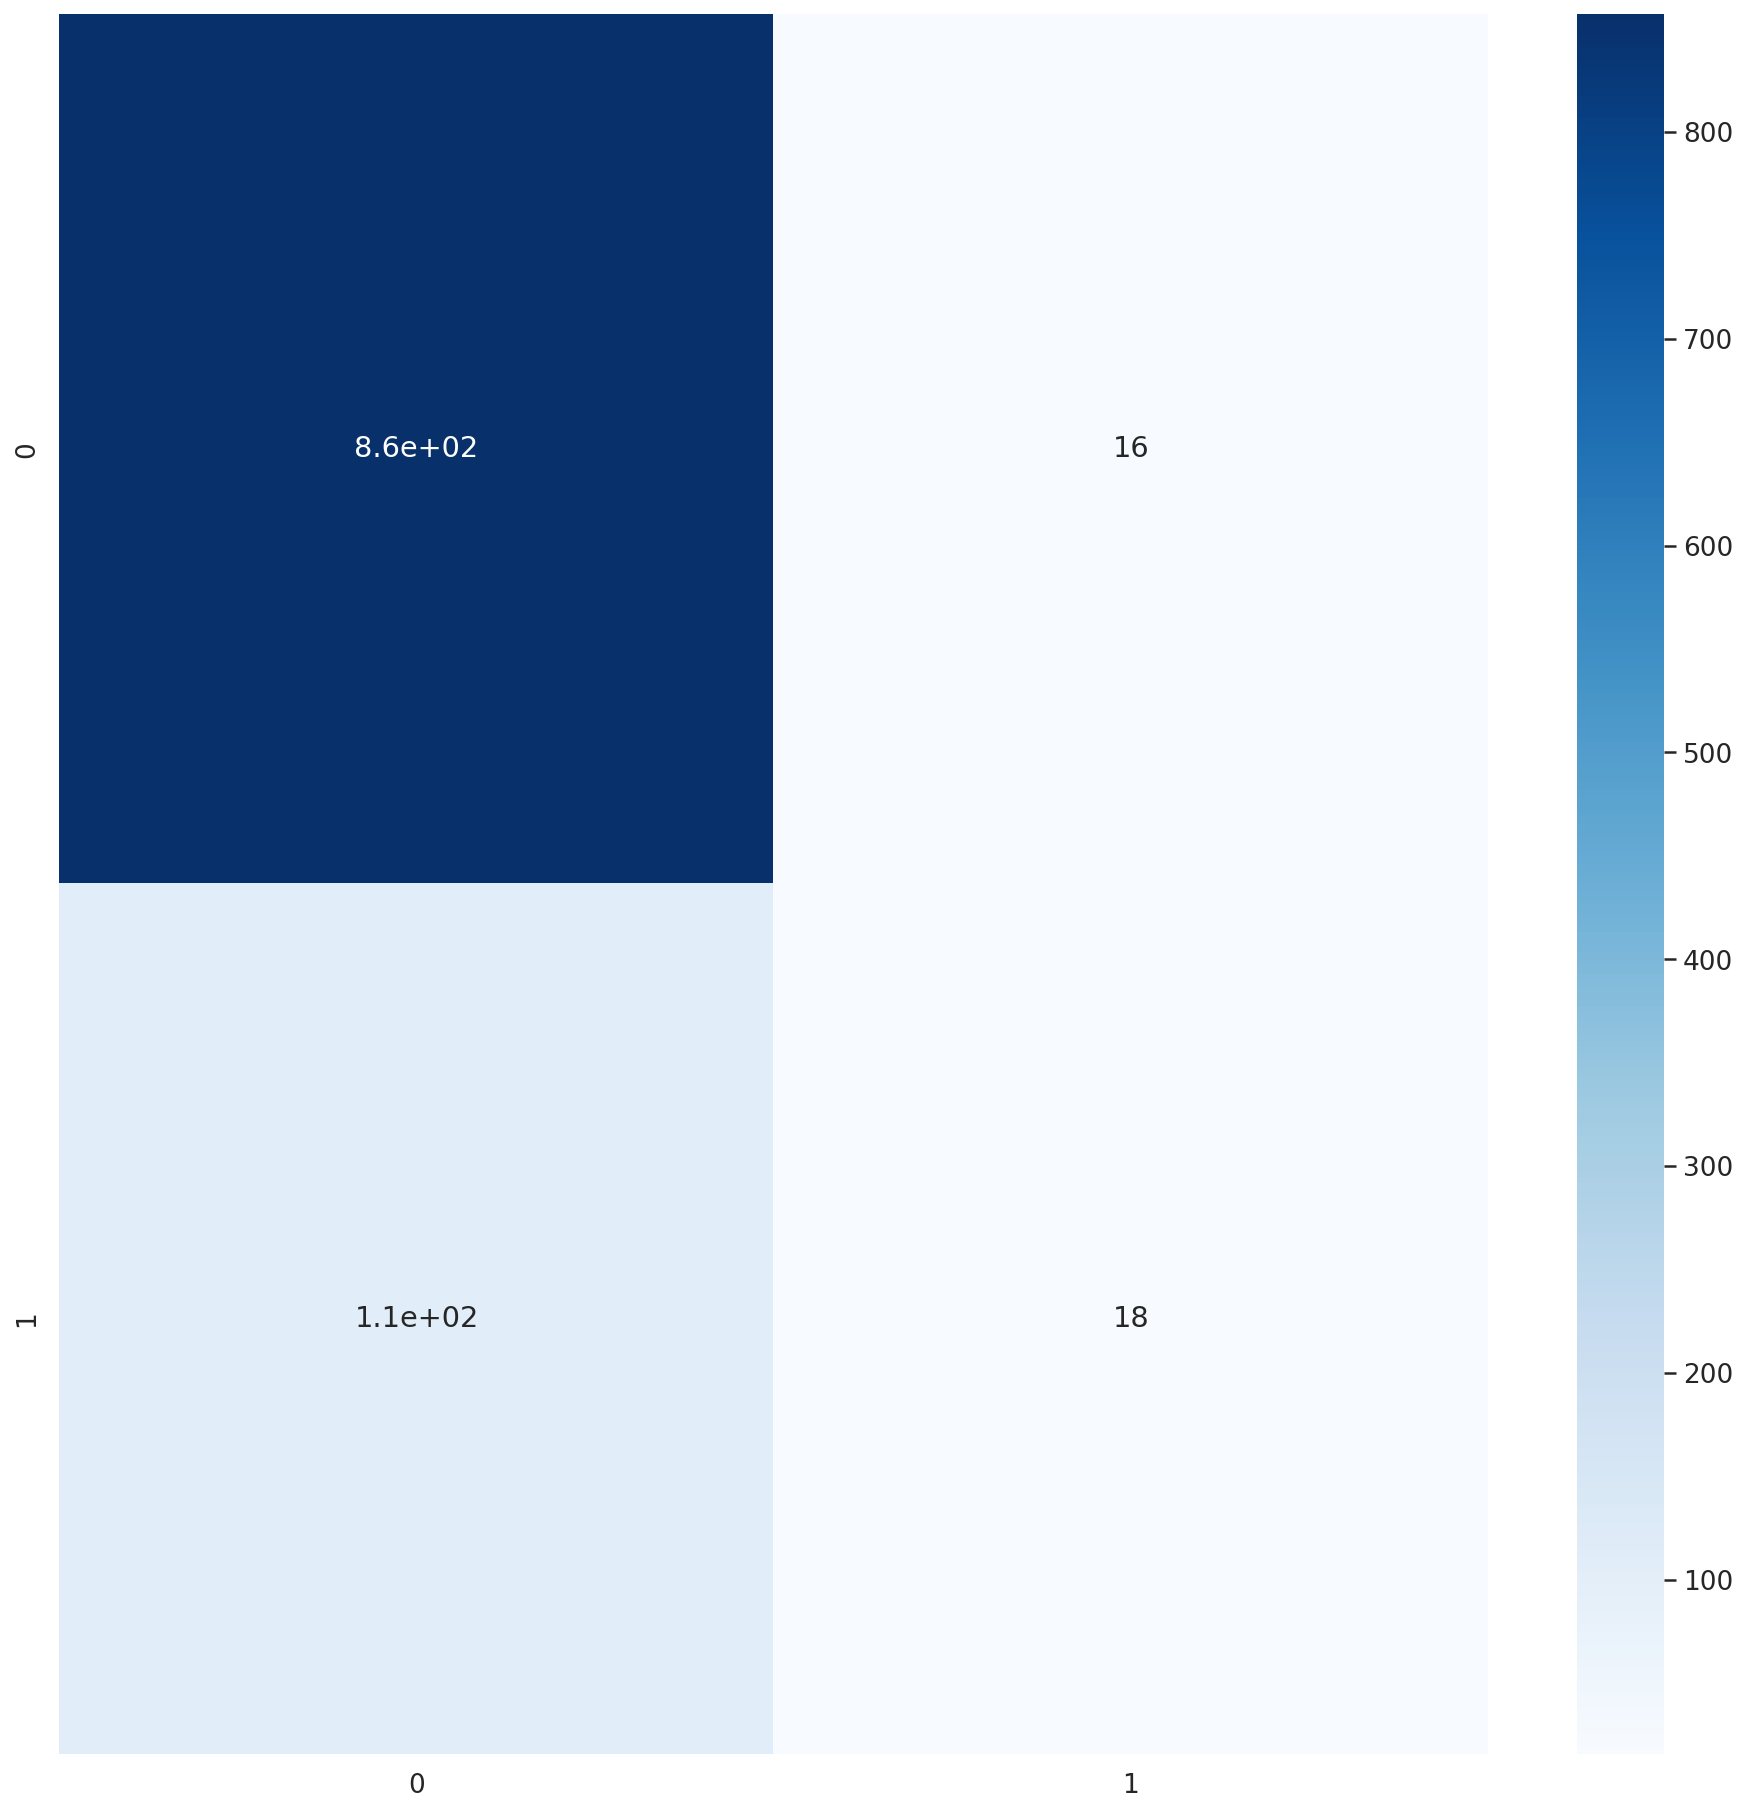

In [52]:
confusionmatrix = confusion_matrix(real_values, y_pred)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(real_values, y_pred))

In [53]:
from sklearn.metrics import roc_curve,confusion_matrix,auc


In [54]:
def roc_curve_plot(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


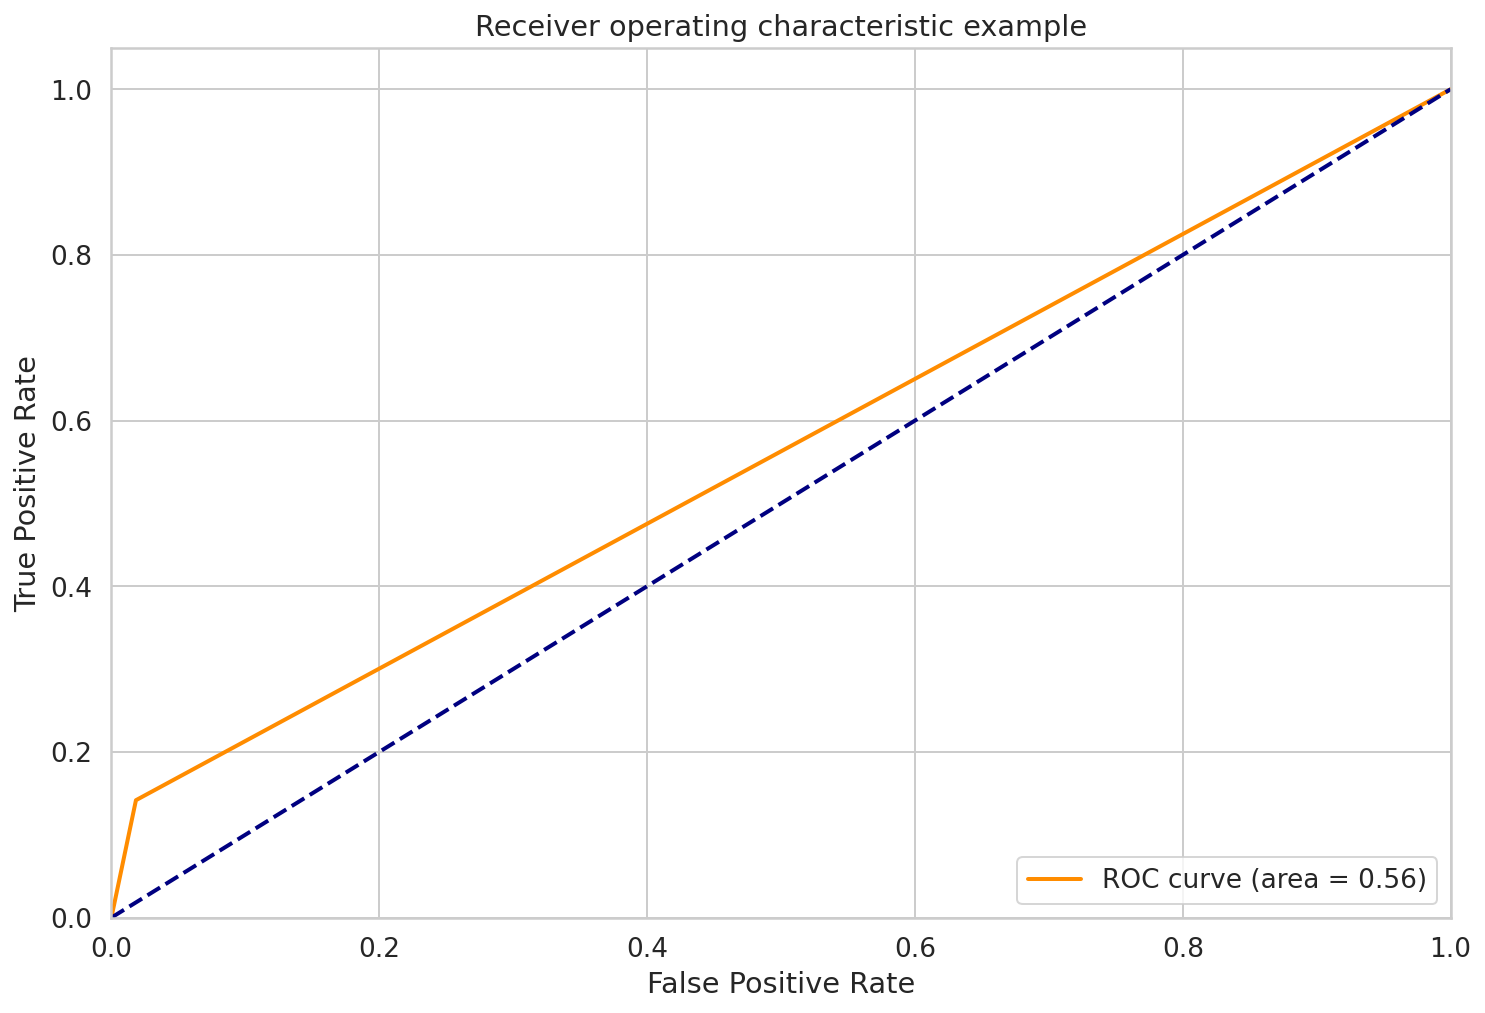

In [56]:
fpr, tpr, _ = roc_curve(real_values,y_pred)
roc_auc = auc(fpr, tpr)
roc_curve_plot(fpr,tpr,roc_auc)


In [ ]:
!unzip -P *MaMiSemEval2022! "/content/drive/MyDrive/MAMI/MAMI DATASET/test.zip"

Archive:  /content/drive/MyDrive/MAMI/MAMI DATASET/test.zip
  inflating: test/15001.jpg          
 extracting: test/15002.jpg          
  inflating: test/15004.jpg          
  inflating: test/15005.jpg          
 extracting: test/15006.jpg          
  inflating: test/15008.jpg          
  inflating: test/15009.jpg          
  inflating: test/15010.jpg          
  inflating: test/15011.jpg          
 extracting: test/15012.jpg          
  inflating: test/15014.jpg          
  inflating: test/15016.jpg          
 extracting: test/15017.jpg          
 extracting: test/15018.jpg          
 extracting: test/15019.jpg          
  inflating: test/15020.jpg          
 extracting: test/15021.jpg          
 extracting: test/15022.jpg          
 extracting: test/15024.jpg          
  inflating: test/15025.jpg          
 extracting: test/15026.jpg          
  inflating: test/15027.jpg          
  inflating: test/15031.jpg          
  inflating: test/15033.jpg          
 extracting: test/15034.jpg 

In [ ]:
while True:
  pass

In [ ]:
actual_test = pd.read_csv("/content/test/Test.csv",sep="\t")

In [ ]:
os.listdir("/content/test")

In [ ]:
actual_test.head()

,file_name,Text Transcription
0,15236.jpg,FACEBOOK SINGLES GROUPS BELIKE WHEN A NEW WOMA...
1,15805.jpg,"SO, IF YOU'RE A FEMINIST HOW CAN YOU EAT DAIRY?"
2,16254.jpg,WHEN A CUTE GIRL LEFT YOUR MESSAGE ON SEEN
3,16191.jpg,Photographing something you want to show every...
4,15952.jpg,HEY BABE CAN YOU MAKE ME A SANDWICH? Hey babe ...


In [ ]:
actual_test['ID'] = list(range(actual_test.shape[0]))

In [ ]:
# actual_test.columns = ['ID','Text']

In [ ]:

class GPReviewDataset_Beta(Dataset):
  def __init__(self, Text,image, ID, processor):
    self.Text = Text
    self.image = image
    self.ID = ID
    # self.tokenizer = tokenizer
    # self.feature_extractor = feature_extractor
    self.processor = processor
    # self.max_len = max_len
  def __len__(self):
    return len(self.Text)
  def __getitem__(self, item):
    img_path = self.image[item]
    img = Image.open("/content/test/"+img_path).convert('RGB')
    img_transformed = _transforms(img)
    Text = str(self.Text[item])
    ID = self.ID[item]
    inputs = processor(text=Text, images=img_transformed, return_tensors="pt", padding='max_length')
    # inputs = inputs.squeeze(0)
    # print(Text)
    # print(img_transformed.shape)
    # print(ID.shape)
    # print(inputs.input_ids.shape)
    # print(Text)
    # print(Text)
    # print(inputs.pixel_values.shape)
    return {
      'input_ids': inputs.input_ids.squeeze(0),
      'attention_mask': inputs.attention_mask.squeeze(0),
      'pixel_values' : inputs.pixel_values.squeeze(0),
      'ID': ID,
      'img_path':img_path
    }



In [ ]:
# class GPReviewDataset_Beta(Dataset):
#   def __init__(self, Text, ID, tokenizer, max_len):
#     self.Text = Text
#     self.ID = ID
#     self.tokenizer = tokenizer
#     self.max_len = max_len
#   def __len__(self):
#     return len(self.Text)
#   def __getitem__(self, item):
#     Text = str(self.Text[item])
#     ID = str(self.ID[item])
#     # Label = self.Label[item]
#     encoding = self.tokenizer.encode_plus(
#       Text,
#       add_special_tokens=True,
#       max_length=self.max_len,
#       return_token_type_ids=False,
#       pad_to_max_length=True,
#       return_attention_mask=True,
#       return_tensors='pt',
#     )
#     return {
#       'text': Text,
#       'input_ids': encoding['input_ids'].flatten(),
#       'attention_mask': encoding['attention_mask'].flatten(),
#       'ID': ID
#       # 'Label': torch.tensor(Label, dtype=torch.long)
#     }

In [ ]:


def create_data_loader(df, processor, batch_size):
  ds = GPReviewDataset_Beta(
    Text=df['Text Transcription'].to_numpy(),
    image = df.file_name.to_numpy(),
    ID=df.ID.to_numpy(),
    processor=processor
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0
  )

In [ ]:
# BATCH_SIZE = 8
# train_data_loader = create_data_loader(df_train, processor, BATCH_SIZE)
# val_data_loader = create_data_loader(df_val, processor, BATCH_SIZE)
# # test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# def create_data_loader(df, tokenizer, max_len, batch_size):
#   ds = GPReviewDataset_Beta(
#     Text=df.Text.to_numpy(),
#     ID=df.ID.to_numpy(),
#     tokenizer=tokenizer,
#     max_len=max_len
#   )
#   return DataLoader(
#     ds,
#     batch_size=batch_size,
#     num_workers=4
#   )

In [ ]:
# BATCH_SIZE = 128
actual_test_data_loader = create_data_loader(actual_test, processor, BATCH_SIZE)


In [ ]:
data = next(iter(actual_test_data_loader))
data.keys()
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
# print(data['Label'].shape)

torch.Size([8, 512])
torch.Size([8, 512])


In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  id = []
  ip = []
  predictions = []
  prediction_probs = []
  # real_values = []

  with torch.no_grad():
    for d in data_loader:

      # texts = d["Text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      pixel_values = d['pixel_values'].to(device)
      # targets = d["Label"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        pixel_values = pixel_values
      )
      _, preds = torch.max(outputs, dim=1)
      ids = d['ID']
      ips = d['img_path']
      # probs = F.softmax(outputs, dim=1)
      
      # review_texts.extend(texts)
      predictions.extend(preds)
      id.extend(ids)
      ip.extend(ips)
      # prediction_probs.extend(probs)
      # real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  idss = id
  ipss = ip
  # prediction_probs = torch.stack(prediction_probs).cpu()
  # real_values = torch.stack(real_values).cpu()
  return idss,ipss,predictions

In [ ]:
idss,ipss,y_pred = get_predictions(
  modell,
  actual_test_data_loader
)

In [ ]:
sub_mysogyni = pd.DataFrame(zip(ipss,y_pred),columns = ['file_path','mysogyni'])

In [ ]:
sub_mysogyni.head()

,file_path,mysogyni
0,15236.jpg,tensor(1)
1,15805.jpg,tensor(1)
2,16254.jpg,tensor(1)
3,16191.jpg,tensor(1)
4,15952.jpg,tensor(1)


In [ ]:
sub_mysogyni['mysogyni']= sub_mysogyni['mysogyni'].apply(lambda x:x.item())

In [ ]:
sub_mysogyni.head()

,file_path,mysogyni
0,15236.jpg,1
1,15805.jpg,1
2,16254.jpg,1
3,16191.jpg,1
4,15952.jpg,1


In [ ]:
sub_mysogyni.to_csv("misogynous.csv",sep ='\t')

In [ ]:
sub_mysogyni['mysogyni'].value_counts()

1    671
0    329
Name: mysogyni, dtype: int64

In [ ]:
import pandas as pd

In [ ]:
sub_mysogyni = pd.read_csv("misogynous.csv",sep ='\t')

In [ ]:
import csv
with open('misogynous.txt', 'w') as f:
  writer = csv.writer(f, delimiter='\t')
  writer.writerows(zip(sub_mysogyni.file_path.values,sub_mysogyni.mysogyni.values))

In [ ]:
sub_s1.columns = ['ID','Labels']

In [ ]:
sub_s1.to_csv("answer.tsv",index=False,sep ="\t")